In [1]:
! pip install icon_registration

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device
import os

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

In [3]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:2], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])

100%|██████████| 9912422/9912422 [00:00<00:00, 28966222.27it/s]


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92682244.70it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 14056432.70it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17721422.11it/s]


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



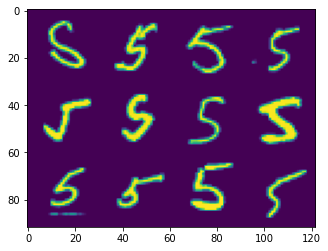

In [4]:
# # Retrieves the first 5 samples of the training split of the MNIST dataset, handwritten digits
ds, _ = icon_registration.data.get_dataset_mnist(split="train", number=5)

# # Get an iterator the the dataset and retrive the first batch
sample_batch = next(iter(ds))[0]

# # Create a grid of the first 12 images with 4 images per row and display it
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [5]:
# # Load image A tensor
image_A = torch.load('image_A.pt')

# # Load image B tensor
image_B = torch.load('image_B.pt')

In [7]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
     inner_net = icon.TwoStepRegistration(
         icon.DownsampleRegistration(inner_net, dimension=2),
         icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
     )
regularizer = ('Diffusion', icon.losses.DiffusionRegularizedNet(inner_net, icon.LNCC(sigma=4), lmbda = 2))
net = regularizer[1]
net.assign_identity_map(sample_batch.shape)

In [ ]:
# Define the GradICON regularizer

# Initialize list to store vector fields for GradICON regularizer
vector_fields = []

# Assuming your directory path where you want to save the vector fields and plot outputs
output_directory = "/work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments"



# Train 10 registration networks for GradICON regularizer
for i in range(10):
    # Initialize network
    net = regularizer[1]

    # Initialize identity map for the provided sample batch
    net.assign_identity_map(sample_batch.shape)

    # Put network in training mode
    net.train()

    # Move the network parameters to the specified device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    optim = torch.optim.Adam(net.parameters(), lr=0.001)

    # Train the network using provided dataset for 5 epochs
    curves = icon.train_datasets(net, optim, ds, ds, epochs=5)

    # Pass both images through the network
   

    net(image_A, image_B)

    # Store vector field tensor
    vector_field = net.phi_AB_vectorfield

    # Append vector field to list
    vector_fields.append(vector_field)

    # Plot and save the outputs
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    show(image_A)
    plt.title('Image A')

    plt.subplot(2, 2, 2)
    show(image_B)
    plt.title('Image B')

    plt.subplot(2, 2, 3)
    show(net.warped_image_A)
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[0].cpu().detach())  # Draws vertical grid lines
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:2], nrow=3)[1].cpu().detach())  # Draws horizontal grid lines
    plt.title('Warped Image A with Vector Field')

    plt.subplot(2, 2, 4)
    show(net.warped_image_A - image_B)
    plt.title('Difference Image (Warped A - B)')

    plt.tight_layout()

    # Save the plot output to a file
    plot_file_path = os.path.join(output_directory, f"plot_output_{i + 1}.png")
    plt.savefig(plot_file_path)
    print(f"Plot output {i + 1} saved to: {plot_file_path}")

# Save the entire list of vector fields to a single file
full_file_path = os.path.join(output_directory, "vector_fields.pt")
torch.save(vector_fields, full_file_path)
print(f"All vector fields saved to: {full_file_path}")

# Vector field: represent the spatial transformations needed to align one image with another. Magnitude of each vector represents the amount of displacement
# applied to the correspponding pixel 

# Interpreatation: Each element of the vector field correspond to a specific pixel in the image, indicating how much and which direction the pixel is needed to be transformed

# Save images A and B as tensors
# torch.save(image_A, 'image_A.pt')
# torch.save(image_B, 'image_B.pt')

100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Plot output 1 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_1.png


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Plot output 2 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_2.png


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Plot output 3 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_3.png


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Plot output 4 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_4.png


100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Plot output 5 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_5.png


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Plot output 6 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_6.png


100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Plot output 7 saved to: /work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/plot_output_7.png


 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]

In [ ]:
# Load the list of vector fields from the saved file
saved_vector_fields = torch.load("/work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/vector_fields.pt")

# Calculate the mean tensor
mean_tensor = torch.mean(torch.stack(saved_vector_fields), dim=0)

# Calculate the standard deviation tensor
std_tensor = torch.std(torch.stack(saved_vector_fields), dim=0)

# Now you can use mean_tensor and std_tensor for further analysis or processing
print("Mean Tensor:")
print(mean_tensor)

print("\nStandard Deviation Tensor:")
print(std_tensor)


# Mean tensor: each element of the mean tensor represents the average displacement or transformation across the corresponding pixels of the images in the dataset

# Standard Deviation Tensor: indicates how much the individual vector fields deviate from the mean tensor at each pixel location. A higher standard deviation implies 
#greater variability in the alignment pattern across the dataset 


In [ ]:
# Save mean tensor to file
mean_file_path = "/work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/mean_tensor.pt"
torch.save(mean_tensor, mean_file_path)
print(f"Mean tensor saved to: {mean_file_path}")

# Save standard deviation tensor to file
std_file_path = "/work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/std_tensor.pt"
torch.save(std_tensor, std_file_path)
print(f"Standard deviation tensor saved to: {std_file_path}")

In [ ]:
# Load the standard deviation tensor
std_tensor = torch.load("/work/users/a/g/agdylan/icon_registration_project/Diffusion_experiments/std_tensor.pt")  # Replace "/path/to/std_tensor.pt" with the actual file path

std_array = std_tensor.cpu().detach().numpy()

# Select a single channel (e.g., channel 0)
std_channel = std_array[:, 0]  # Assuming you want to select channel 0

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(std_channel[0], cmap='jet', interpolation='nearest')  # Assuming you want to plot the first image in the batch
plt.colorbar(label='Standard Deviation')
plt.title('Heatmap of Standard Deviation Tensor')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()